# Comparision between MultiMatch and NWayMatch

MultiMatch is the current default Multi-catalog matcher in the Rubin DM stack.  It performs a series
of two-way catalog matches, updating the reference catalog as it goes.

NWayMatch is a simple proof-of-concept for multi-catalog matching.
Rather than do a series of 2-way matches, it clusters sources and then resolves
the cluster membership to ensure that each input catalog only contributes at most
one source to any given "object".

This example assumes that you:

    1. Have downloaded the data here:  https://lsst.ncsa.illinois.edu/~yusra/nway-matcher/
    2. Are running from the directory you download the data into.
    3. Have run MultiMatch on those data (using multiMatch.py to generate matchCat.fits)
    4. Have run NWayMatch on those data (using nway.py to generate out.fits)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
import numpy as np
from astropy import table
from astropy.table import Table

#### Read the input tables

In [21]:
cAssoc = Table.read('out.fits', hdu=1)
oAssoc = Table.read('out.fits', hdu=2)
cStats = Table.read('out.fits', hdu=3)
oStats = Table.read('out.fits', hdu=4)
mAssoc = Table.read('matchCat.fits')

In [35]:
(cStats['nObject'] != 1).sum()

64065

In [26]:
print(len(oStats))
print((oStats['nSrcs'] == 1).sum())
print(len(cStats))
print((cStats['nSrcs'] == 1).sum())

1050857
462058
910162
367735


#### Quick check on the input tables.

Note that there are 8636020 total sources in the input catalogs.

Right away we see that MultiMatch is leaving some sources unassociated.  This is
actually b/c of the way that it is removing 'ambiguities', i.e., cases were we
have multiple sources from a single catalog inside the matching radius.

In [4]:
print("Total number of sources assocaited to NWayMatch Clusters: %i" % len(cAssoc))
print("Total number of sources assocaited to NWayMatch Objects: %i" % len(oAssoc))
print("Total number of sources assocaited to MutliMatch Objects: %i" % len(mAssoc))

Total number of sources assocaited to NWayMatch Clusters: 8636020
Total number of sources assocaited to NWayMatch Objects: 8636020
Total number of sources assocaited to MutliMatch Objects: 7923128


#### Lets look at the number of sources per cluster and per object in NWayMatch

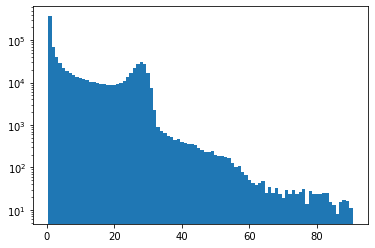

In [5]:
# This is the number of source per cluster.   The high-end tail depends on the cell size
_ = plt.hist(cStats['nSrcs'], bins=np.linspace(0.5, 90.5, 91))
plt.yscale('log')

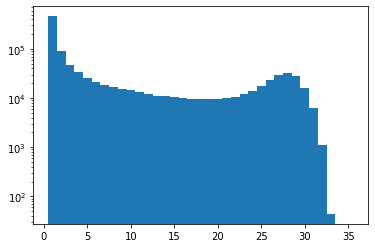

In [7]:
# This is the number of sources per object.  It can not exceed the number of input catalogs
_ = plt.hist(oStats['nSrcs'], bins=np.linspace(0.5, 35.5, 36))
plt.yscale('log')

### Now lets compare the number of sources per object from MultiMatch.

We see that NWayMatch is giving slightly more associations.  Again, this is b/c of the
associations that have been removed.

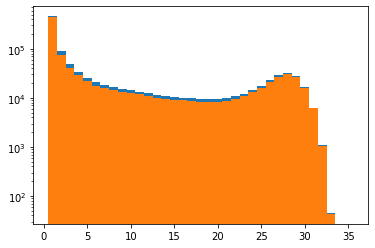

In [9]:
# This is the number of sources per object
# We are using np.bincount to count the number of times a given object id occurs in the association catalog
_ = plt.hist(oStats['nSrcs'], bins=np.linspace(0.5, 35.5, 36))
_ = plt.hist(np.bincount(mAssoc['object']), bins=np.linspace(0.5, 35.5, 36))
plt.yscale('log')

### Now let's make vectors that keep track of how sources are in each object

    srcCountC -> Number of sources in each cluster
    srcCountO -> Number of sources in each NWayMatch object
    srcCountM -> Number of sources in each MultiMatch object

In [10]:
srcCountC = np.bincount(cAssoc['object'])
srcCountM = np.bincount(mAssoc['object'])
srcCountO = np.bincount(oAssoc['object'])

#### Now let's join the tables, using the 'id' column as the matching key

This could take about a minute

In [11]:
jj = table.join(oAssoc, mAssoc, join_type='outer', keys='id')

In [12]:
jc = table.join(cAssoc, mAssoc, join_type='outer', keys='id')

#### Now we can get parallel arrays, with the number of sources associated to each input source

    mo -> number of sources in the associated NWayMatch Object
    mc -> number of sources in the associated NWayMatch Cluster
    mm -> number of sources in the associated MultiMatch Object

In [13]:
mo = srcCountO[jj['object_1'].data]
mc = srcCountC[jc['object_1'].data]
mm = np.where(jj['object_2'].data.mask, 0, srcCountM[jj['object_2'].data])
mask = mo != mm
mask2 = mc != mm

Make a density plot of the number of sources in the NWayMatch cluster versus the number of associated sources in MultiMatch.   Note that the Clusters can have many more sources than the MultiMatch objects.  If the same matching radius is used, and is the same as the cell size, there should never be fewer sources in a cluster than in a MultiMatch object.  

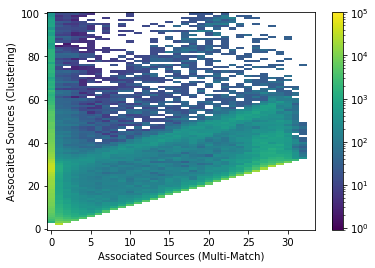

In [14]:
norm=colors.LogNorm(vmin=0.9, vmax=1e5)
oo = plt.hist2d(mm[mask2], mc[mask2], bins=[np.linspace(-0.5, 33.5, 35), np.linspace(-0.5, 100.5, 102)], norm=norm)
cb = plt.colorbar()
_ = plt.xlabel("Associated Sources (Multi-Match)")
_ = plt.ylabel("Assocaited Sources (Clustering)")

Make a density plot of the number of sources in the NWayMatch objects versus the number of associated sources in MultiMatch.   Note that feature where nSrcMultiMatch == 0.  These are sources that have had all their associated removed b/c of ambiguities.

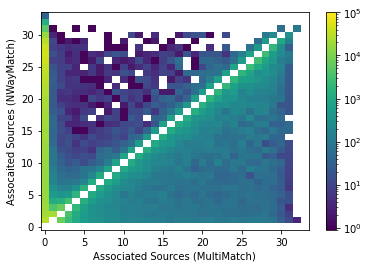

In [15]:
norm=colors.LogNorm(vmin=0.9, vmax=1e5)
oo = plt.hist2d(mm[mask], mo[mask], bins=[np.linspace(-0.5, 33.5, 35), np.linspace(-0.5, 33.5, 35)], norm=norm)
cb = plt.colorbar()
_ = plt.xlabel("Associated Sources (MultiMatch)")
_ = plt.ylabel("Assocaited Sources (NWayMatch)")

Now let's make a histogram of the difference in the number of sources
associated to any given source.  (I.e,. there is one entry per source, and the
x-axis value is the difference in the number of associated sources as found
by MultiMatch and NWayMatch)  

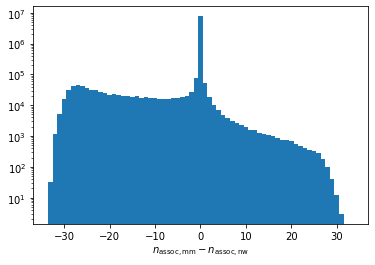

In [16]:
plt.yscale('log')
_ = plt.hist(mm-mo, bins=np.linspace(-33.5, 33.5, 68))
_ = plt.xlabel(r"$n_{\rm assoc, mm} - n_{\rm assoc, nw}$")

Now let's make a histogram of the difference in the number of sources
associated to a cluster as compared to the number associated to a MultiMatch
object.  Really this is just telling us about the cell size and the number of
sources inside the matching radius.

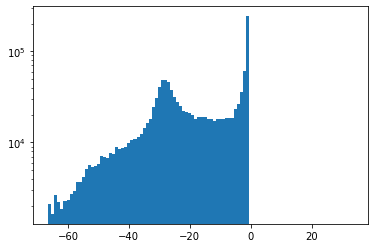

In [17]:
plt.yscale('log')
_ = plt.hist(mm[mask2]-mc[mask2], bins=np.linspace(-66.5, 33.5, 101))